In [1]:
import cv2
import numpy as np
import skimage
import PIL

# Test thư viện
print(f"OpenCV Version: {cv2.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Scikit-Image Version: {skimage.__version__}")
print(f"Pillow Version: {PIL.__version__}")

OpenCV Version: 4.8.0
NumPy Version: 1.24.4
Scikit-Image Version: 0.21.0
Pillow Version: 9.5.0


In [2]:
import os

data_dir = "data/"
image_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]

print("Danh sách ảnh trong thư mục data/:")
for img in image_files:
    print(img)

Danh sách ảnh trong thư mục data/:
landsat_day.jpg
landsat_night.jpg
landscape.jpg
mono_landscape.jpg
mri_brain.jpg
tir_cat.jpg
xray_chest.jpg


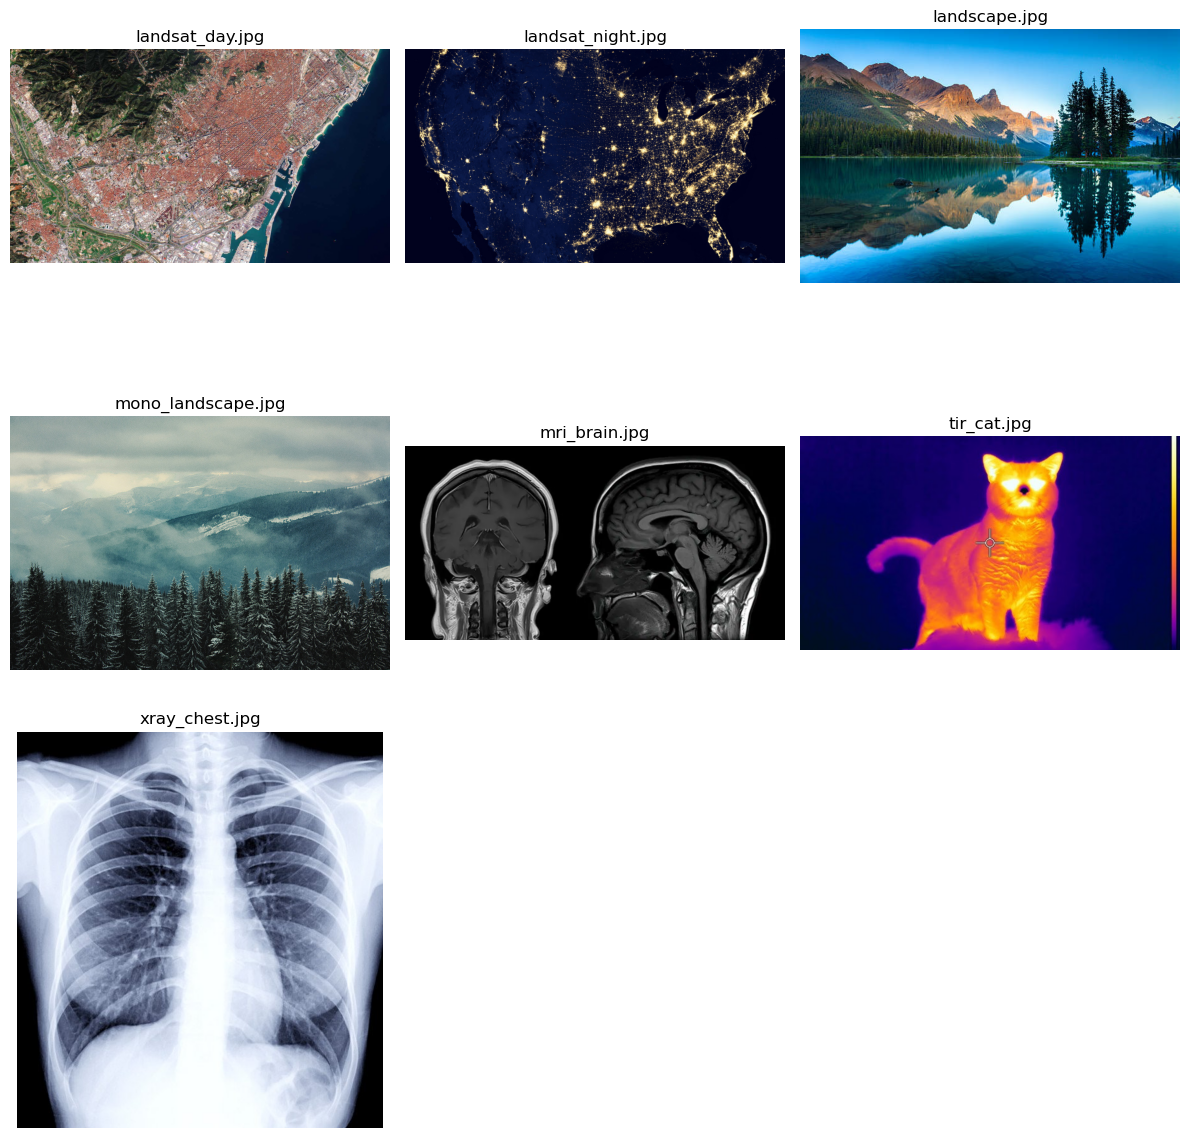

In [3]:
import matplotlib.pyplot as plt
import cv2

cols = min(3, len(image_files))  
rows = (len(image_files) + cols - 1) // cols  

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

axes = axes if rows > 1 else [axes]

for idx, img_name in enumerate(image_files):
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    ax = axes[idx // cols][idx % cols]  
    ax.imshow(img)
    ax.set_title(img_name)
    ax.axis("off")

for i in range(len(image_files), rows * cols):
    axes[i // cols][i % cols].axis("off")

plt.tight_layout()
plt.show()

- Histogram $ H(I) $ của một ảnh $ I $ được định nghĩa:

$$
H(I,k) = \sum_{x, y} \delta(I(x,y)=k)
$$

Với $ k $ là mức xám hoặc giá trị màu trong một kênh.

- Hàm phân phối tích lũy (CDF):

$$
\text{CDF}(k) = \sum^k_{i=0} H(I,i)
$$

Để tìm giá trị pixel mới trong $ I^{'}(x,y) $, ta cần ánh xạ thông qua CDF của ảnh tham chiếu.

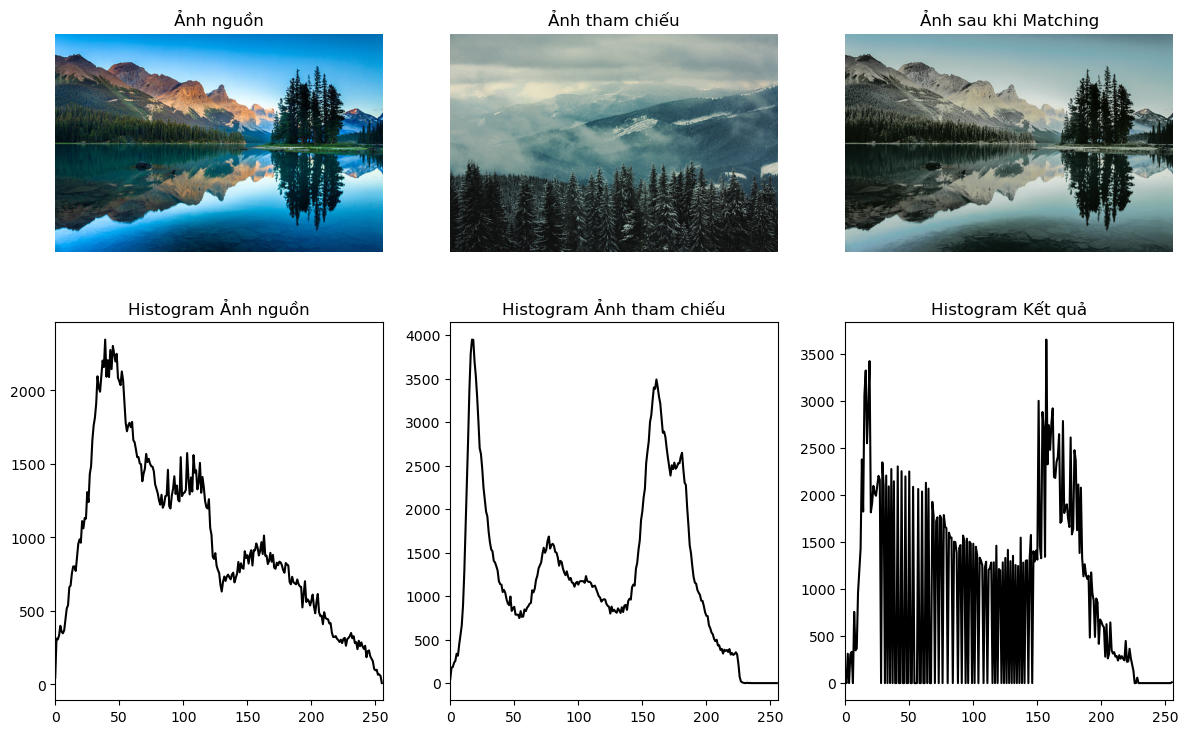

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_cdf(hist):
    return hist.cumsum() / hist.sum()

def match_histogram(source, reference):
    matched = np.zeros_like(source)
    
    for channel in range(source.shape[2]):
        hist_src, bins = np.histogram(source[..., channel], bins=256, range=(0, 256))
        hist_ref, _ = np.histogram(reference[..., channel], bins=256, range=(0, 256))
        
        cdf_src = calculate_cdf(hist_src)
        cdf_ref = calculate_cdf(hist_ref)
        
        mapping = np.interp(cdf_src, cdf_ref, np.arange(256))
        matched[..., channel] = np.round(mapping[source[..., channel]]).astype(np.uint8)
    
    return matched

def plot_results(src_img, ref_img, matched_img):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    axes[0, 0].imshow(cv2.cvtColor(src_img, cv2.COLOR_YCrCb2RGB))
    axes[0, 0].set_title("Ảnh nguồn")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(cv2.cvtColor(ref_img, cv2.COLOR_YCrCb2RGB))
    axes[0, 1].set_title("Ảnh tham chiếu")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(cv2.cvtColor(matched_img, cv2.COLOR_YCrCb2RGB))
    axes[0, 2].set_title("Ảnh sau khi Matching")
    axes[0, 2].axis("off")

    for i, img in enumerate([src_img[..., 0], ref_img[..., 0], matched_img[..., 0]]):
        hist, bins = np.histogram(img.flatten(), 256, [0,256])
        axes[1, i].plot(hist, color='black')
        axes[1, i].set_title(["Histogram Ảnh nguồn", "Histogram Ảnh tham chiếu", "Histogram Kết quả"][i])
        axes[1, i].set_xlim([0, 256])

    plt.tight_layout()
    plt.show()

data_dir = "data/"
land_hismatch = cv2.imread(data_dir + "landscape.jpg")
monoland_hismatch = cv2.imread(data_dir + "mono_landscape.jpg")

land_hismatch = cv2.cvtColor(land_hismatch, cv2.COLOR_BGR2YCrCb)
monoland_hismatch = cv2.cvtColor(monoland_hismatch, cv2.COLOR_BGR2YCrCb)

matched_landscape = match_histogram(land_hismatch, monoland_hismatch)
plot_results(land_hismatch, monoland_hismatch, matched_landscape)

## Histogram Matching với Ảnh Màu

### Chuyển đổi không gian màu
- Ảnh được chuyển từ BGR sang **YCrCb** để tách độ sáng (Y) khỏi thông tin màu (Cr, Cb).
- Matching chỉ thực hiện trên kênh **Y** để tránh làm lệch màu tổng thể.

### Tính toán Histogram và CDF
- Histogram của từng kênh được tính bằng `np.histogram()`.
- CDF (Cumulative Distribution Function) được tính bằng `hist.cumsum() / hist.sum()` để chuẩn hóa.

### Mapping Histogram
- CDF của ảnh nguồn được ánh xạ sang CDF của ảnh tham chiếu bằng `np.interp()`.
- Mỗi giá trị cường độ pixel trong ảnh nguồn được thay thế bằng giá trị gần nhất từ ảnh tham chiếu.

### Hiển thị Kết Quả
- So sánh ảnh nguồn, ảnh tham chiếu và ảnh kết quả.
- Hiển thị Histogram của kênh **Y** trước và sau khi matching.

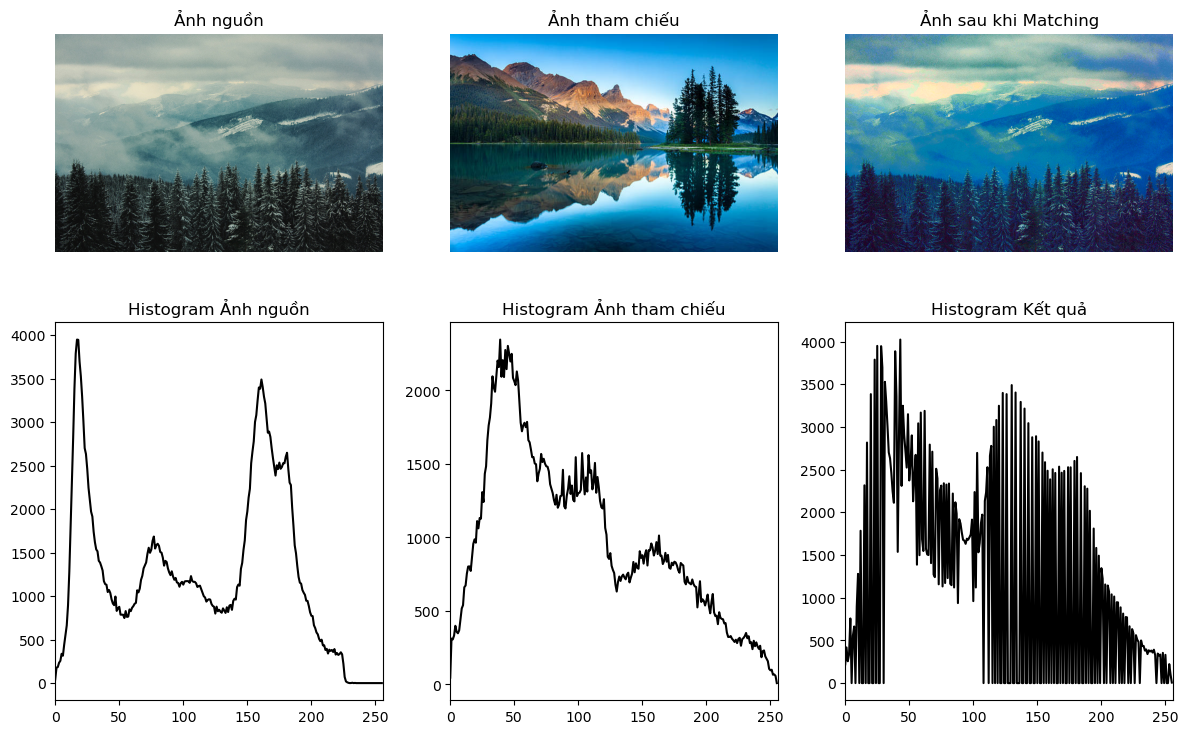

In [10]:
matched_landscape_rev = match_histogram(monoland_hismatch, land_hismatch)
plot_results(monoland_hismatch, land_hismatch, matched_landscape_rev)

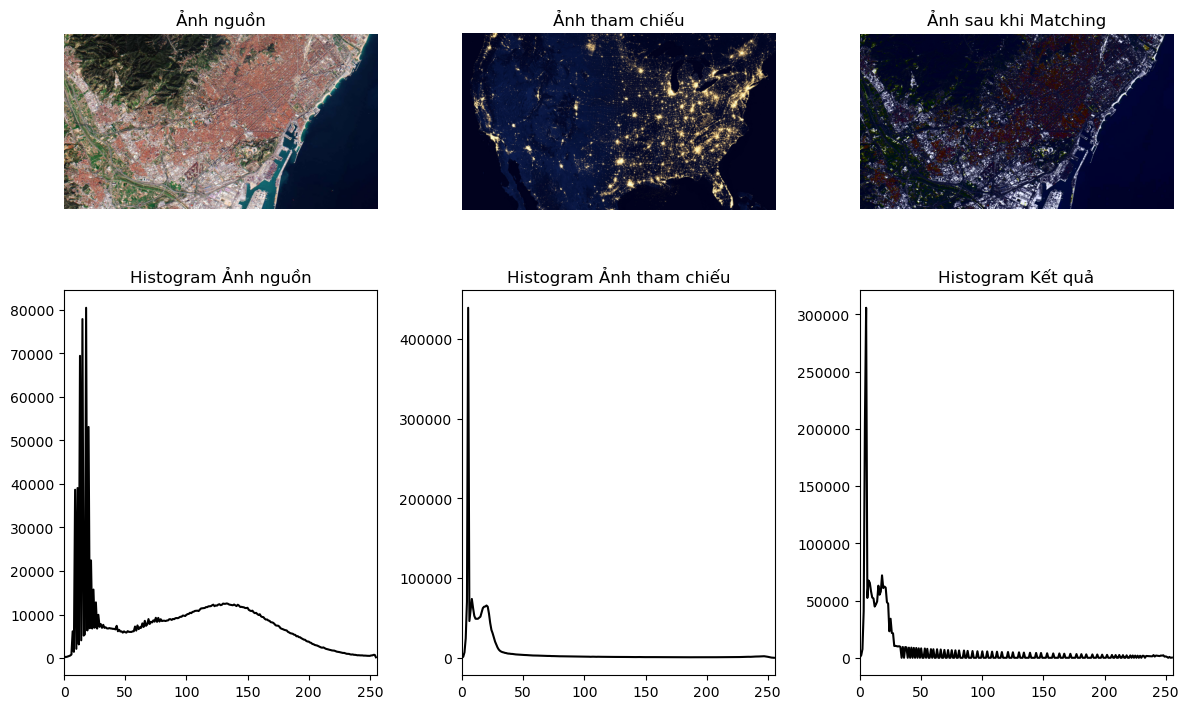

In [8]:
landsatday_hismatch = cv2.imread(data_dir + "landsat_day.jpg")
landsatnight_hismatch = cv2.imread(data_dir + "landsat_night.jpg")

landsatday_hismatch = cv2.cvtColor(landsatday_hismatch, cv2.COLOR_BGR2YCrCb)
landsatnight_hismatch = cv2.cvtColor(landsatnight_hismatch, cv2.COLOR_BGR2YCrCb)

matched_landsat = match_histogram(landsatday_hismatch, landsatnight_hismatch)
plot_results(landsatday_hismatch, landsatnight_hismatch, matched_landsat)

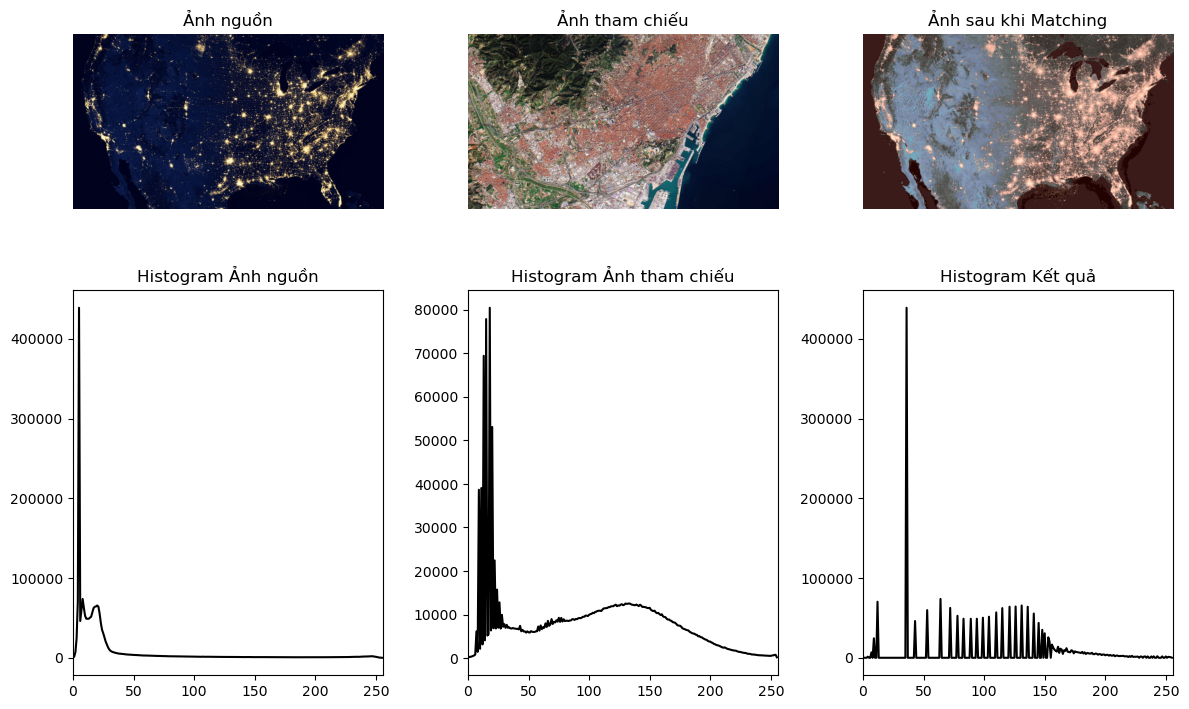

In [9]:
matched_landsat_rev = match_histogram(landsatnight_hismatch, landsatday_hismatch)
plot_results(landsatnight_hismatch, landsatday_hismatch, matched_landsat_rev)

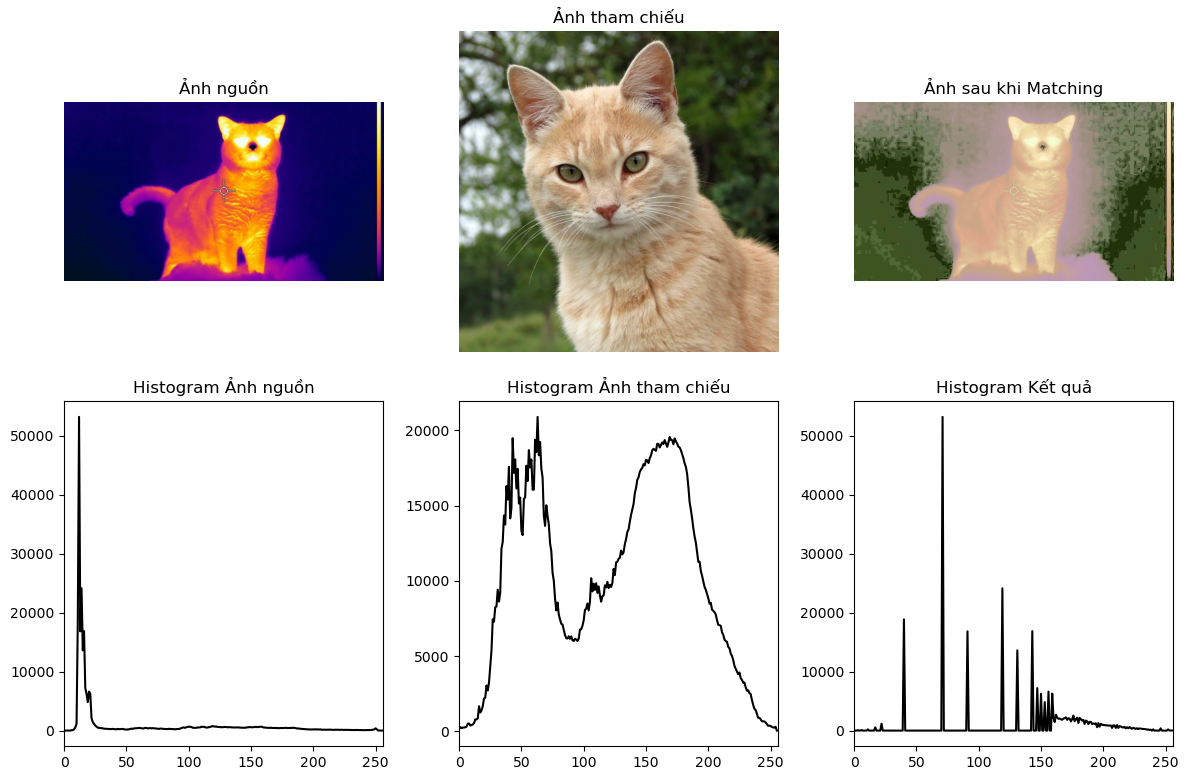

In [12]:
tircat_hismatch = cv2.imread(data_dir + "tir_cat.jpg")
cat_hismatch = cv2.imread(data_dir + "cat.jpg")

tir_cat = cv2.cvtColor(tircat_hismatch, cv2.COLOR_BGR2YCrCb)
cat_hismatch = cv2.cvtColor(cat_hismatch, cv2.COLOR_BGR2YCrCb)


matched_cat = match_histogram(tir_cat, cat_hismatch)
plot_results(tir_cat, cat_hismatch, matched_cat)

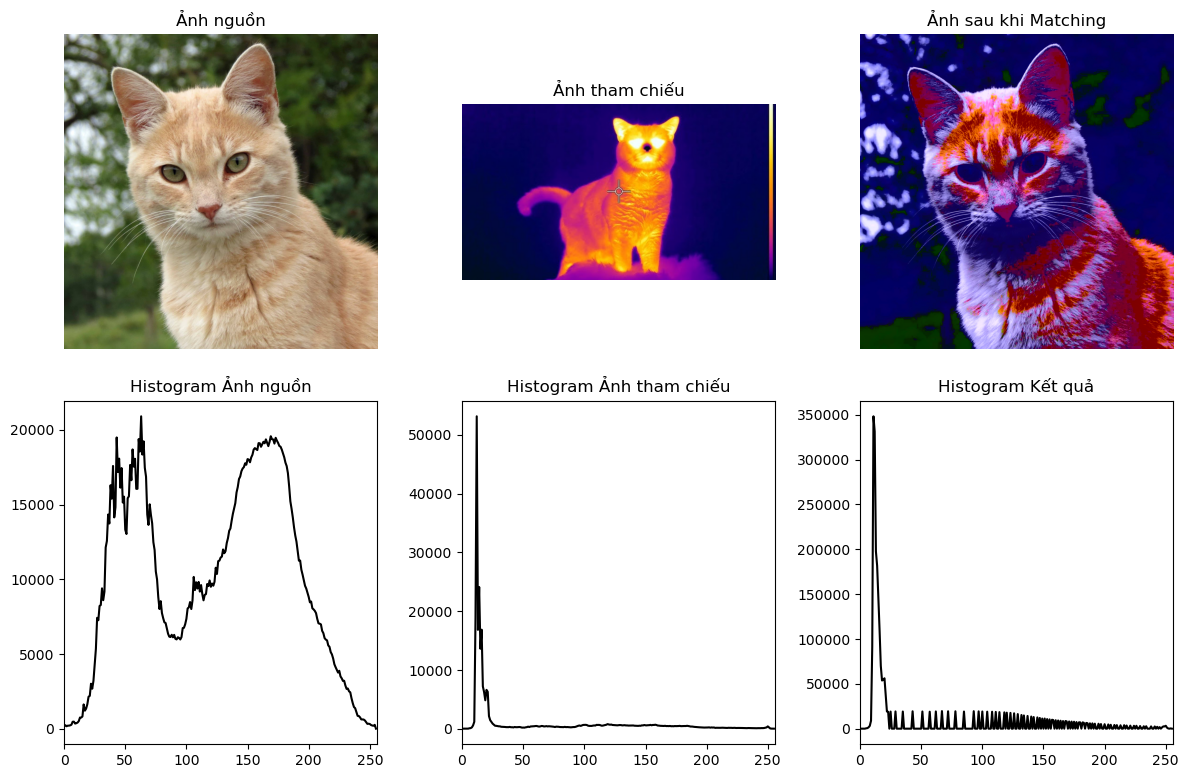

In [13]:
matched_cat_rev = match_histogram(cat_hismatch, tir_cat)
plot_results(cat_hismatch, tir_cat, matched_cat_rev)

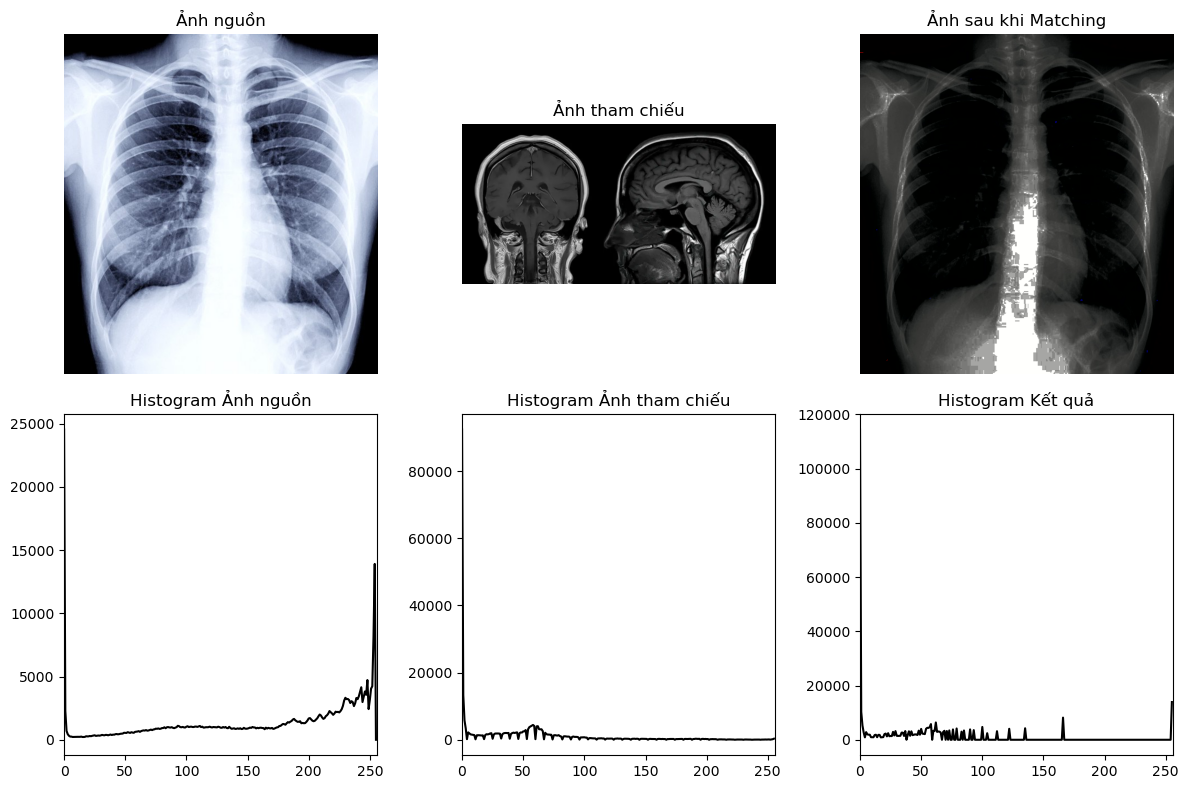

In [14]:
xray_hismatch = cv2.imread(data_dir + "xray_chest.jpg")
mri_hismatch = cv2.imread(data_dir + "mri_brain.jpg")

xray_hismatch = cv2.cvtColor(xray_hismatch, cv2.COLOR_BGR2YCrCb)
mri_hismatch = cv2.cvtColor(mri_hismatch, cv2.COLOR_BGR2YCrCb)


matched_med = match_histogram(xray_hismatch, mri_hismatch)
plot_results(xray_hismatch, mri_hismatch, matched_med)

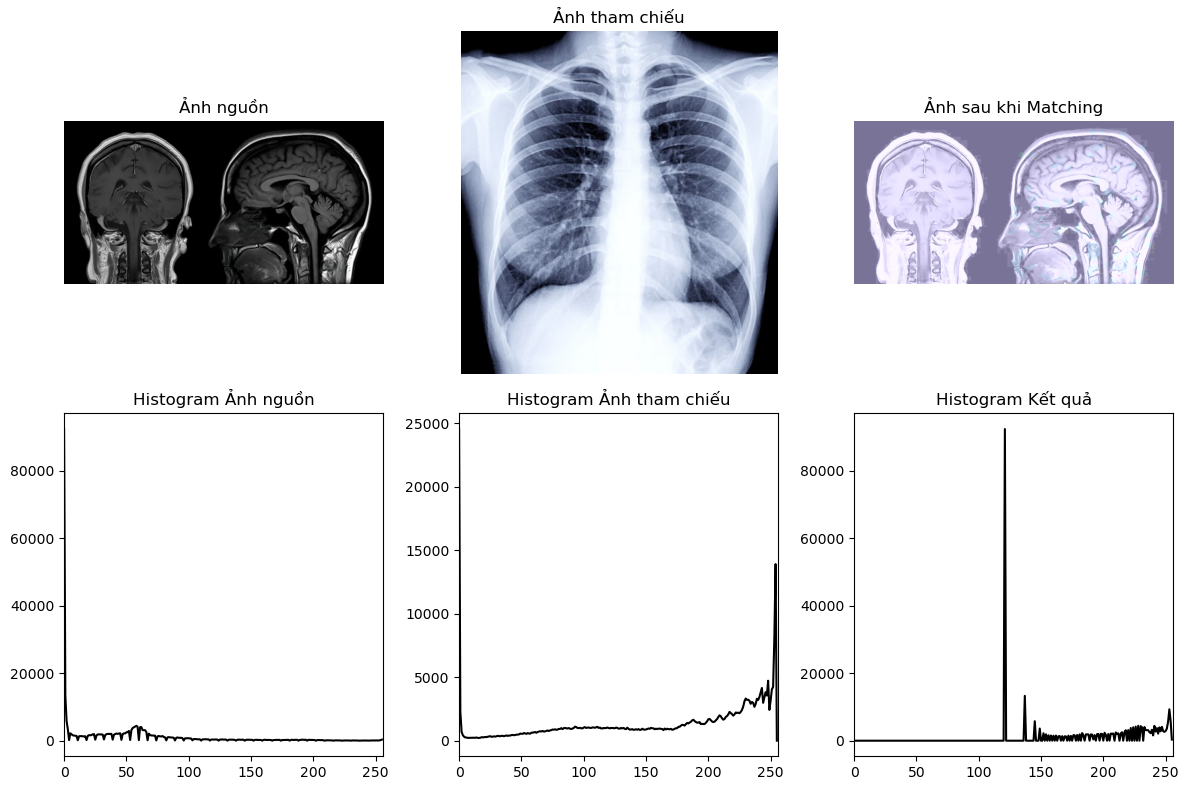

In [15]:
matched_med_rev = match_histogram(mri_hismatch, xray_hismatch)
plot_results(mri_hismatch, xray_hismatch, matched_med_rev)

## Nhận xét về Hiệu quả của Histogram Matching

#### Trường hợp hoạt động tốt:
1. **Ảnh phong cảnh màu vs. phong cảnh đơn sắc**
   - Matching giúp ảnh màu có phổ sáng gần với ảnh đơn sắc, tạo hiệu ứng chuyển đổi hợp lý.
   - Histogram của kênh độ sáng (Y) khớp khá tốt với ảnh tham chiếu.
   
2. **Ảnh vệ tinh ban ngày vs. ban đêm**
   - Matching giúp mô phỏng sự thay đổi độ sáng giữa hai ảnh cùng loại.
   - Kết quả phản ánh rõ sự khác biệt ánh sáng theo thời gian.

---

#### Trường hợp hoạt động kém:
1. **Ảnh nhiệt (TIR) vs. ảnh thông thường**
   - Ảnh nhiệt lưu trữ dữ liệu theo nhiệt độ, không phải ánh sáng khả kiến.
   - Dù có khớp histogram, ảnh kết quả không có ý nghĩa trực quan.

2. **Ảnh X-ray vs. MRI**
   - X-ray phản ánh sự hấp thụ tia X qua mô cứng, trong khi MRI hiển thị tín hiệu từ mô mềm.
   - Histogram Matching chỉ điều chỉnh độ sáng, không thể làm nổi bật cấu trúc mong muốn.

---

#### Nguyên nhân khiến Histogram Matching không hiệu quả:
- **Ảnh có dải giá trị pixel khác nhau về bản chất**
  - Histogram Matching chỉ thay đổi phân bố sáng mà không thay đổi thông tin vật lý của ảnh.

- **Cấu trúc ảnh quá khác biệt**
  - Nếu hai ảnh có chi tiết và kết cấu khác nhau, matching không thể làm cho chúng giống nhau về nội dung.

- **Không gian màu khác nhau**
  - Matching chỉ trên kênh Y (độ sáng) có thể không đủ để đạt kết quả mong muốn.

---

#### Hướng cải thiện:
- Matching trên **từng kênh màu (RGB, Lab)** thay vì chỉ kênh Y.
- Thử **Histogram Equalization trước khi Matching** để cân bằng phân bố sáng.
- Dùng **phương pháp học sâu (GANs, Feature Mapping)** nếu muốn chuyển đổi ảnh giữa các miền dữ liệu khác nhau.